# Detect German traffic signs

In this project I will create a model which can identify the type of traffic sign from an image.
At the end I will also define a function which takes an url link as input (poining to traffic sign image),
load it, preprocess it and then display it with the predicted label!

Here you can download the [Dataset](https://bitbucket.org/jadslim/german-traffic-signs)

In [1]:
%matplotlib inline

import requests
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from six.moves import cPickle as pickle
import random
import cv2
import os

### Import data

In [2]:
def load_pickle_data(path):
    """Given a path to a pickle object,
    return images and labels"""
    with open(path, "rb") as F:
        data = pickle.load(F)
    return data["features"], data["labels"]

In [3]:
X_train, Y_train = load_pickle_data("german-traffic-signs/train.p")
X_val, Y_val = load_pickle_data("german-traffic-signs/valid.p")
X_test, Y_test = load_pickle_data("german-traffic-signs/test.p")

In [4]:
print(f"train: {X_train.shape}\nvalid: {X_val.shape}\ntest: {X_test.shape}")

train: (34799, 32, 32, 3)
valid: (4410, 32, 32, 3)
test: (12630, 32, 32, 3)


### Make sure the number of images and labels is the same

In [5]:
assert(X_train.shape[0]==Y_train.shape[0]), "The number of images in the train set doesn't match the number of labels"
assert(X_val.shape[0]==Y_val.shape[0]), "The number of images in the validation set doesn't match the number of labels"
assert(X_test.shape[0]==Y_test.shape[0]), "The number of images in the test set doesn't match the number of labels"

### Import traffic sign names

In [6]:
data = pd.read_csv("german-traffic-signs/signnames.csv")

### Visualize images and corresponding labels

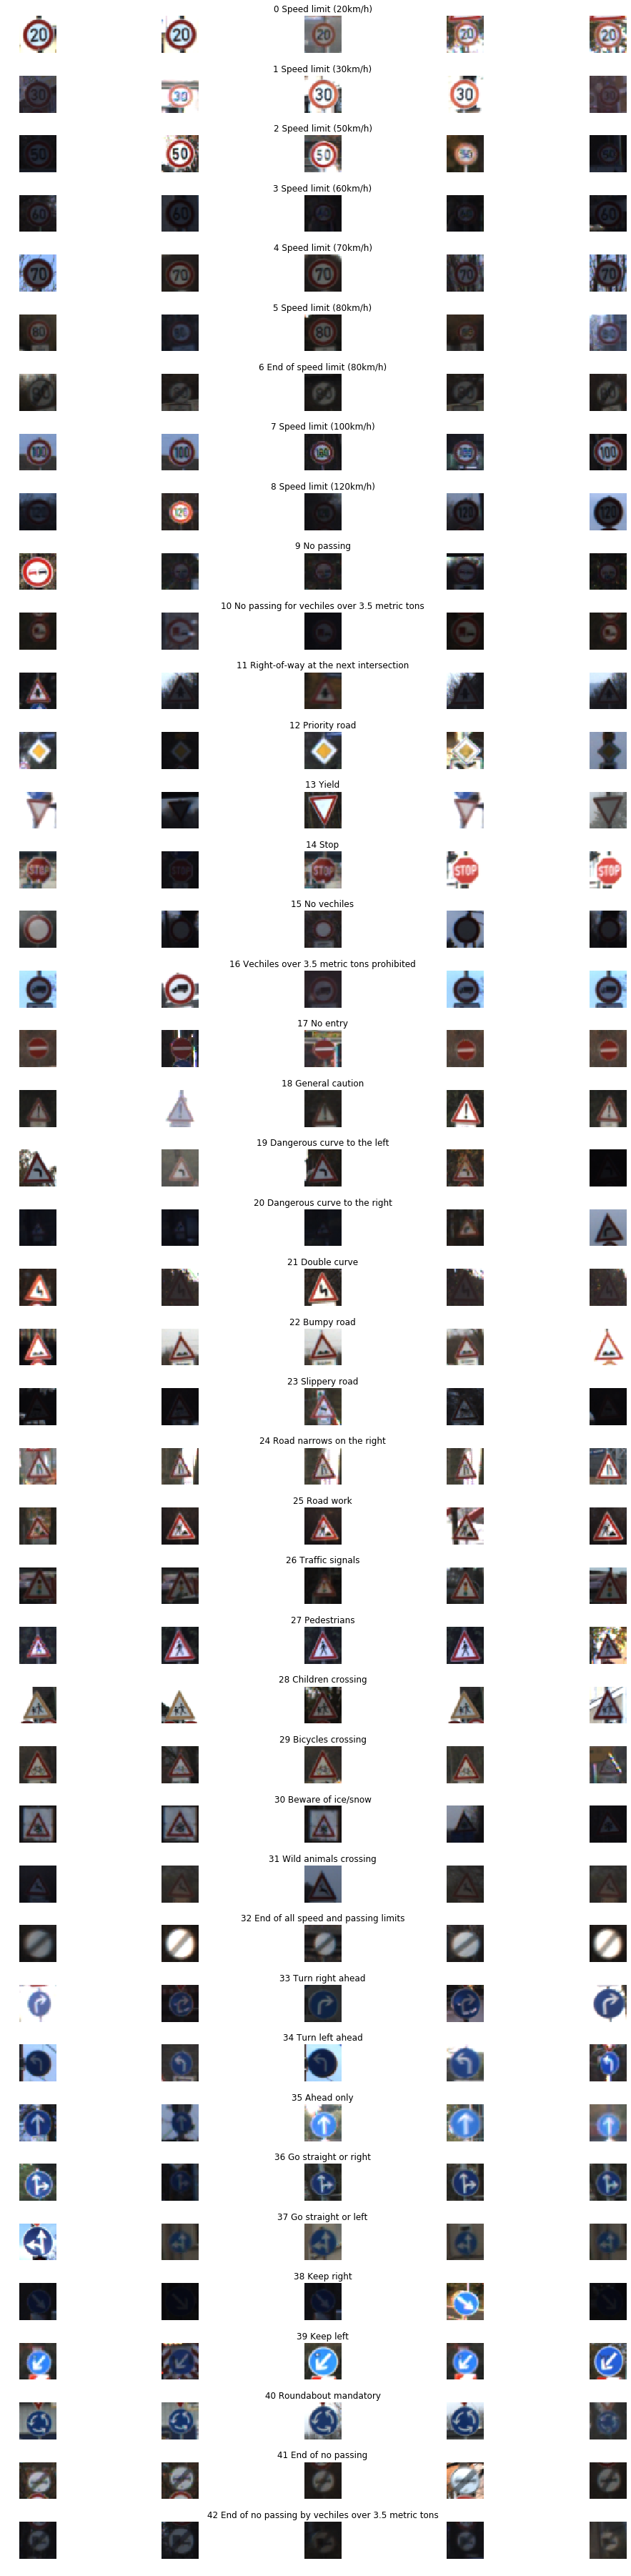

In [7]:
np.random.seed(37)
num_of_samples = []
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(14, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[Y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, 100), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title("{} {}".format(j, row['SignName']))
            num_of_samples.append(len(x_selected))

### Visualize number of images per class

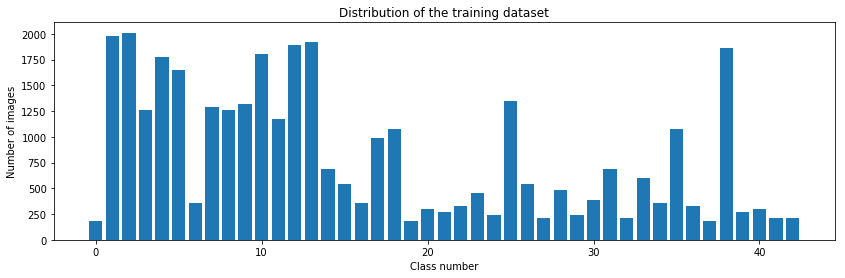

In [8]:
plt.figure(figsize=(14, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

### Visualize a random image before preprocessing

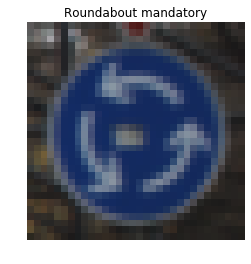

In [9]:
index = random.randint(0, X_train.shape[0] - 1)
plt.imshow(X_train[index])
plt.axis("off")
plt.title(data["SignName"][Y_train[index]])
plt.show()

### Preprocess images

In [10]:
def preprocess(img):
    """Convert the image to gray scale, equalize the histogram
    to improve the contrast, normalize it by devinding the image by 255
    and finally the image is reshaped with a depth of 1 for the CNN"""
    return np.reshape(cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)) / 255, (32,32,1))

In [11]:
X_train = np.array(list(map(preprocess, X_train)))
X_val = np.array(list(map(preprocess, X_val)))
X_test = np.array(list(map(preprocess, X_test)))

### Visualize a preprocessed image

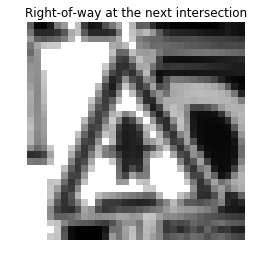

In [12]:
index = random.randint(0, X_train.shape[0] - 1)
plt.imshow(X_train[index].reshape(32,32), cmap='gray')
plt.axis("off")
plt.title(data["SignName"][Y_train[index]])
plt.show()

### Make data augmentation to improve performance

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.25,
                             height_shift_range=0.25,
                             zoom_range=0.3,
                             shear_range=0.1,
                             rotation_range=10)

datagen.fit(X_train)

### Visualize example images after data augmentation

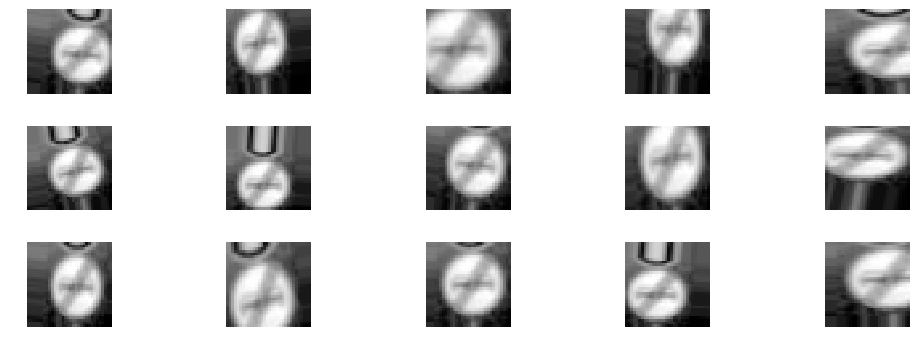

In [14]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(14, 5))
fig.tight_layout()
for i, (image, label) in enumerate(datagen.flow(X_train[20:21], Y_train[20:21], batch_size=1)):
    if i >= 15:
        break
    axs[i//5][i%5].imshow(image.reshape(32, 32), cmap=plt.get_cmap("gray"))
    axs[i//5][i%5].axis("off")

### One hot encoding all labels

In [15]:
Y_train = to_categorical(Y_train, 43)
Y_val = to_categorical(Y_val, 43)
Y_test = to_categorical(Y_test, 43)

### Define NN model

In [16]:
def mymodel():
    # Define input layer (as a placeholder tensor)
    input_l = tf.keras.Input(shape=(X_train[0].shape), name='input_l')
    
    # hidden layers
    net = Conv2D(60, (5, 5), activation="relu")(input_l)
    net = Conv2D(60, (5, 5), activation="relu")(net)
    net = MaxPooling2D((2, 2))(net)
    net = Dropout(.1)(net)
    net = Conv2D(30, (3, 3), activation="relu")(net)
    net = Conv2D(30, (3, 3), activation="relu")(net)
    net = MaxPooling2D((2, 2))(net)
    net = Dropout(.2)(net)
    net = Flatten()(net)
    net = Dense(units=500, activation="relu")(net)
    net = Dropout(.5)(net)
    
    # Add final output layer with softmax activation
    output_l = Dense(units=num_classes, activation="softmax", name='output_l')(net)
    
    # Create the model and compile it
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    model.compile(Adam(lr=1e-4, decay=5e-10), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [17]:
model = mymodel()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_l (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
__________

### Train model

In [18]:
checkpointer = ModelCheckpoint(filepath='saved_models/best_weights.hdf5', 
                               verbose=1, save_best_only=True, monitor='val_acc')

stopper = EarlyStopping(monitor='val_acc', patience=20)

batch_size=50

history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              steps_per_epoch=2000, epochs=200, 
                              validation_data=datagen.flow(X_val, Y_val, batch_size=batch_size),
                              shuffle=True, callbacks=[checkpointer, stopper])

Epoch 1/200
1996/2000 [============================>.] - ETA: 0s - loss: 3.2271 - acc: 0.1217
Epoch 00001: val_acc improved from -inf to 0.27551, saving model to saved_models/best_weights.hdf5
2000/2000 [==============================] - 26s 13ms/step - loss: 3.2261 - acc: 0.1218 - val_loss: 2.6093 - val_acc: 0.2755
Epoch 2/200
1995/2000 [============================>.] - ETA: 0s - loss: 2.3309 - acc: 0.3144
Epoch 00002: val_acc improved from 0.27551 to 0.39410, saving model to saved_models/best_weights.hdf5
2000/2000 [==============================] - 25s 12ms/step - loss: 2.3306 - acc: 0.3144 - val_loss: 2.0572 - val_acc: 0.3941
Epoch 3/200
1998/2000 [============================>.] - ETA: 0s - loss: 1.9256 - acc: 0.4168
Epoch 00003: val_acc improved from 0.39410 to 0.49705, saving model to saved_models/best_weights.hdf5
2000/2000 [==============================] - 25s 12ms/step - loss: 1.9254 - acc: 0.4169 - val_loss: 1.6773 - val_acc: 0.4971
Epoch 4/200
1995/2000 [=================

1996/2000 [============================>.] - ETA: 0s - loss: 0.2642 - acc: 0.9203
Epoch 00027: val_acc did not improve from 0.94490
2000/2000 [==============================] - 25s 12ms/step - loss: 0.2643 - acc: 0.9203 - val_loss: 0.2010 - val_acc: 0.9392
Epoch 28/200
1995/2000 [============================>.] - ETA: 0s - loss: 0.2595 - acc: 0.9208
Epoch 00028: val_acc did not improve from 0.94490
2000/2000 [==============================] - 24s 12ms/step - loss: 0.2595 - acc: 0.9208 - val_loss: 0.1887 - val_acc: 0.9433
Epoch 29/200
1998/2000 [============================>.] - ETA: 0s - loss: 0.2416 - acc: 0.9267
Epoch 00029: val_acc improved from 0.94490 to 0.94649, saving model to saved_models/best_weights.hdf5
2000/2000 [==============================] - 24s 12ms/step - loss: 0.2417 - acc: 0.9267 - val_loss: 0.1823 - val_acc: 0.9465
Epoch 30/200
1996/2000 [============================>.] - ETA: 0s - loss: 0.2339 - acc: 0.9284
Epoch 00030: val_acc improved from 0.94649 to 0.94649, s

1997/2000 [============================>.] - ETA: 0s - loss: 0.1343 - acc: 0.9585
Epoch 00055: val_acc did not improve from 0.96803
2000/2000 [==============================] - 25s 12ms/step - loss: 0.1342 - acc: 0.9585 - val_loss: 0.1109 - val_acc: 0.9662
Epoch 56/200
1996/2000 [============================>.] - ETA: 0s - loss: 0.1331 - acc: 0.9598
Epoch 00056: val_acc did not improve from 0.96803
2000/2000 [==============================] - 25s 12ms/step - loss: 0.1331 - acc: 0.9598 - val_loss: 0.0988 - val_acc: 0.9680
Epoch 57/200
1998/2000 [============================>.] - ETA: 0s - loss: 0.1312 - acc: 0.9610
Epoch 00057: val_acc improved from 0.96803 to 0.97007, saving model to saved_models/best_weights.hdf5
2000/2000 [==============================] - 25s 13ms/step - loss: 0.1311 - acc: 0.9610 - val_loss: 0.1015 - val_acc: 0.9701
Epoch 58/200
1999/2000 [============================>.] - ETA: 0s - loss: 0.1298 - acc: 0.9601
Epoch 00058: val_acc did not improve from 0.97007
2000/2

Epoch 84/200
1996/2000 [============================>.] - ETA: 0s - loss: 0.0920 - acc: 0.9723
Epoch 00084: val_acc did not improve from 0.97868
2000/2000 [==============================] - 24s 12ms/step - loss: 0.0921 - acc: 0.9723 - val_loss: 0.0980 - val_acc: 0.9728
Epoch 85/200
1999/2000 [============================>.] - ETA: 0s - loss: 0.0922 - acc: 0.9717
Epoch 00085: val_acc did not improve from 0.97868
2000/2000 [==============================] - 24s 12ms/step - loss: 0.0923 - acc: 0.9717 - val_loss: 0.0735 - val_acc: 0.9773
Epoch 86/200
1997/2000 [============================>.] - ETA: 0s - loss: 0.0915 - acc: 0.9723
Epoch 00086: val_acc did not improve from 0.97868
2000/2000 [==============================] - 24s 12ms/step - loss: 0.0914 - acc: 0.9724 - val_loss: 0.0794 - val_acc: 0.9737
Epoch 87/200
1999/2000 [============================>.] - ETA: 0s - loss: 0.0892 - acc: 0.9730
Epoch 00087: val_acc did not improve from 0.97868
2000/2000 [==============================] - 

1996/2000 [============================>.] - ETA: 0s - loss: 0.0709 - acc: 0.9785
Epoch 00114: val_acc did not improve from 0.98050
2000/2000 [==============================] - 25s 12ms/step - loss: 0.0709 - acc: 0.9785 - val_loss: 0.0748 - val_acc: 0.9771
Epoch 115/200
1995/2000 [============================>.] - ETA: 0s - loss: 0.0686 - acc: 0.9789
Epoch 00115: val_acc did not improve from 0.98050
2000/2000 [==============================] - 25s 12ms/step - loss: 0.0686 - acc: 0.9789 - val_loss: 0.0703 - val_acc: 0.9782
Epoch 116/200
1998/2000 [============================>.] - ETA: 0s - loss: 0.0695 - acc: 0.9789
Epoch 00116: val_acc improved from 0.98050 to 0.98186, saving model to saved_models/best_weights.hdf5
2000/2000 [==============================] - 25s 12ms/step - loss: 0.0695 - acc: 0.9789 - val_loss: 0.0638 - val_acc: 0.9819
Epoch 117/200
1995/2000 [============================>.] - ETA: 0s - loss: 0.0682 - acc: 0.9795
Epoch 00117: val_acc did not improve from 0.98186
200

Epoch 144/200
1998/2000 [============================>.] - ETA: 0s - loss: 0.0605 - acc: 0.9818
Epoch 00144: val_acc did not improve from 0.98254
2000/2000 [==============================] - 24s 12ms/step - loss: 0.0605 - acc: 0.9818 - val_loss: 0.0731 - val_acc: 0.9816
Epoch 145/200
1996/2000 [============================>.] - ETA: 0s - loss: 0.0616 - acc: 0.9814
Epoch 00145: val_acc did not improve from 0.98254
2000/2000 [==============================] - 24s 12ms/step - loss: 0.0617 - acc: 0.9814 - val_loss: 0.0657 - val_acc: 0.9812
Epoch 146/200
1999/2000 [============================>.] - ETA: 0s - loss: 0.0606 - acc: 0.9818
Epoch 00146: val_acc improved from 0.98254 to 0.98254, saving model to saved_models/best_weights.hdf5
2000/2000 [==============================] - 24s 12ms/step - loss: 0.0606 - acc: 0.9818 - val_loss: 0.0628 - val_acc: 0.9825
Epoch 147/200
1996/2000 [============================>.] - ETA: 0s - loss: 0.0598 - acc: 0.9817
Epoch 00147: val_acc did not improve fr

1997/2000 [============================>.] - ETA: 0s - loss: 0.0535 - acc: 0.9836
Epoch 00173: val_acc did not improve from 0.98458
2000/2000 [==============================] - 24s 12ms/step - loss: 0.0535 - acc: 0.9836 - val_loss: 0.0529 - val_acc: 0.9841
Epoch 174/200
1996/2000 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9837
Epoch 00174: val_acc did not improve from 0.98458
2000/2000 [==============================] - 24s 12ms/step - loss: 0.0539 - acc: 0.9837 - val_loss: 0.0525 - val_acc: 0.9846
Epoch 175/200
1997/2000 [============================>.] - ETA: 0s - loss: 0.0533 - acc: 0.9844
Epoch 00175: val_acc did not improve from 0.98458
2000/2000 [==============================] - 25s 12ms/step - loss: 0.0533 - acc: 0.9844 - val_loss: 0.0811 - val_acc: 0.9800
Epoch 176/200
1998/2000 [============================>.] - ETA: 0s - loss: 0.0538 - acc: 0.9835
Epoch 00176: val_acc did not improve from 0.98458
2000/2000 [==============================] - 25s 12ms/s

In [19]:
model.load_weights('saved_models/best_weights.hdf5')

### Visualize training process

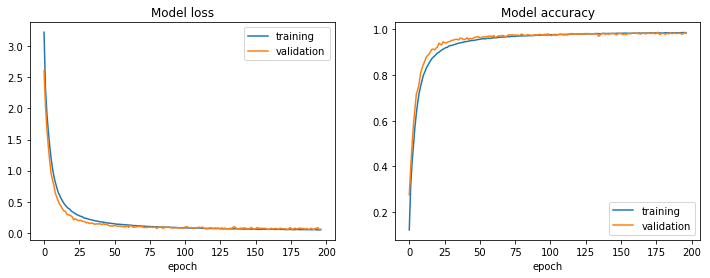

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

axs[0].plot(history.history["loss"])
axs[0].plot(history.history["val_loss"])
axs[0].legend(["training", "validation"])
axs[0].set_title("Model loss")
axs[0].set_xlabel("epoch")
axs[1].plot(history.history["acc"])
axs[1].plot(history.history["val_acc"])
axs[1].legend(["training", "validation"])
axs[1].set_title("Model accuracy")
axs[1].set_xlabel("epoch")
plt.show()

In [21]:
score = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Score: {score[0]}\nTest Accuracy: {score[1]}")

Test Score: 0.09248035740565398
Test Accuracy: 0.9794932700109595


### Test the model using images from the web!

In [22]:
def predict_fromWeb(url):
    r = requests.get(url, stream=True)
    img_raw = Image.open(r.raw)
    img = preprocess(cv2.resize(np.asarray(img_raw), (32, 32))).reshape(1, 32, 32, 1)
    prediction = data['SignName'][model.predict(img).argmax(axis=-1)].to_string()
    print("Predicted sign: ", prediction)
    plt.imshow(img_raw)
    plt.show()

Predicted sign:  1    Speed limit (30km/h)


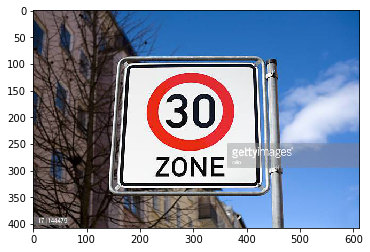

In [26]:
predict_fromWeb('https://media.gettyimages.com/photos/german-traffic-sign-speed-limit-30-kilometers-per-hour-picture-id171144479?s=612x612')

Predicted sign:  25    Road work


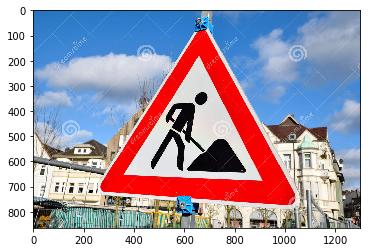

In [27]:
predict_fromWeb('https://raw.githubusercontent.com/dhnkrn/Traffic-Sign-Classifier/master/images/german_1.jpg')